In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import sys

sys.path.append("../")
from plotting_utils import color_boxplot, custom_marginal_plot

from sbi.inference import SNPE, prepare_for_sbi
from sbi.simulators.simutils import simulate_in_batches
from sbi.analysis import pairplot
from consbi.simulators import RuleSimulator, DistanceRuleSimulator, peters_rule_subcellular
from consbi.simulators.utils import collect_synapse_counts_over_depth

from consbi import DATA_PATH, RESULTS_PATH


import matplotlib as mpl
plt.rcParams.update(mpl.rcParamsDefault)
plt.style.use('../plotting_settings.mplstyle')

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load inferred posteriors from file
we performed inference for each subvolumes size for the neuron-level rule (5 sizes), and once for the synapse-level rule given subvolume size 1µm.

So, six files in total.

In [2]:
# Select posterior files.
files = [
    "amortized_posterior_N1000000_PetersSubCellular_ss50_ep288.p",
    "amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs50_ep253.p",
    "amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs25_ep261.p",
    "amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs10_ep130.p",
    "amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs5_ep242.p",
    "amortized_posterior_N1000000_PetersCubesCutoff_ss50_cs1_ep211.p",
]

In [3]:
xo_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
N = 1000
css = [1, 50, 25, 10, 5, 1]
rule_labels = [rf"voxel size {i}$\mu$m" for i in css]
xo = torch.tensor([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])

## Load results or re-run? 
Generating the results will take some time, consider re-loading them from `results_folder/distance-based-rules-comparison.p`.

In [4]:
regenerate_data = False

if not regenerate_data:
    with open(RESULTS_PATH.joinpath("distance-based-rules-comparison.p"), "rb") as fh:
        xs, xos, xos_fixed, maps, features, ths, thos = pickle.load(fh).values()

## Calculate posterior MAP for each file

In [5]:
maps = []
for idx, file in enumerate(files):
    with open(RESULTS_PATH.joinpath(file), "rb") as fh:
        prior, posterior_v14, seed, de = pickle.load(fh).values()
    # update posterior to sbi version 19.2
    posterior = SNPE(prior).build_posterior(density_estimator=posterior_v14.net)
    posterior.set_default_x(xo)
    maps.append(posterior.map(show_progress_bars=False))


Optimization was interrupted after 779 iterations. 



Optimization was interrupted after 177 iterations. 


### Generate data predicted from distance assumption (Peters' rule) /  without inference 

To compare inference vs. fixed rules (Peters' rule), we first get the predictive distributions for these two rules: for the synapse-level and for the neuron-level.

In [ ]:
# Simulate subcellular rule with fixed p=1 (Peters)
with open(files[0], "rb") as fh:
    prior, posterior, seed, de = pickle.load(fh).values()
simulator = RuleSimulator(
            DATA_PATH.joinpath("subcellular_features"),
            peters_rule_subcellular,
            verbose=False,
            num_subsampling_pairs=50,
            experiment_name="peters-subcellular",
        )
batch_simulator, prior = prepare_for_sbi(simulator, prior)
xos_fixed = []
xos_fixed.append(simulate_in_batches(
    batch_simulator, torch.ones(1000, 1), sim_batch_size=10, num_workers=20
))

In [ ]:
# Simulate common cubes rule with fixed th=1 (Peters)
with open(files[1], "rb") as fh:
    prior, posterior, seed, de = pickle.load(fh).values()
    

model = DistanceRuleSimulator(
    path_to_model=DATA_PATH.joinpath("cube_model"),
    num_subsampling_pairs=50,
    cube_size=1, 
    feature_set_name="set-6",
)

def simulator(th):
    return model.rule(th, feature=model.common_cubes, connection_fun=model.cutoff_rule)
batch_simulator, prior = prepare_for_sbi(simulator, prior)
xos_fixed.append(simulate_in_batches(
    batch_simulator, torch.ones(1000, 1), sim_batch_size=10, num_workers=20
))

### Prior and posterior predictive for each posterior.
Next we sample the posterior and simulate the posterior (and prior) predictives for each of the six posteriors (one for synapse-level, and five for neuron-level cube sizes).

In [ ]:
ths = []
thos = []
xs = []
xos = []
features = []

for idx, file in enumerate(files):
    with open(file, "rb") as fh:
        prior, posterior_v14, seed, de = pickle.load(fh).values()
    posterior = SNPE(prior).build_posterior(density_estimator=posterior_v14.net)
    
    # construct simulator appropriate for current idx.
    if idx == 0: # synapse-level posterior, subcellular features.
        simulator = RuleSimulator(
            DATA_PATH.joinpath("subcellular_features"),
            peters_rule_subcellular,
            verbose=False,
            num_subsampling_pairs=50,
            experiment_name="peters-subcellular",
        )
    else:  # neuron-level, all other indices.     
        model = DistanceRuleSimulator(
            path_to_model=DATA_PATH.joinpath("cube_model"),
            num_subsampling_pairs=50,
            cube_size=css[idx], 
            feature_set_name="set-6",  # feature set for neuron-level cubes.
        )
        features.append(model.common_cubes)

        def simulator(th):
            return model.rule(th, feature=model.common_cubes, connection_fun=model.cutoff_rule)       

    # generate params.
    ths.append(prior.sample((N,)))
    thos.append(posterior.sample((N,), x=xo, show_progress_bars=False))
    
    # run simulations.
    simulator, prior = prepare_for_sbi(simulator, prior)
    xs.append(simulate_in_batches(simulator, ths[-1], sim_batch_size=10, num_workers=20))
    xos.append(simulate_in_batches(simulator, thos[-1], sim_batch_size=10, num_workers=20))

## Save results

In [8]:
if regenerate_data:
    with open(RESULTS_PATH.joinpath("distance-based-rules-comparison.p"), "wb") as fh:
        pickle.dump(dict(
                        xs=xs,  # prior predictives
                        xos=xos,  # posterior predictives
                        xos_fixed=xos_fixed,  # predictives null-model
                        maps=maps,  # MAP estimates
                        features=features,  # common cube features
                        ths=ths,  # prior samples
                        thos=thos,  # posterior samples
                    ),
                    fh)

## Plotting

In [5]:
# Prepare plotting
# The features are the number of shared subvolumes needed for figure panel A.
features = np.array(features).squeeze().T

# from list to tensor
thos = torch.stack(thos).squeeze().T.numpy()

In [6]:
# load data for number of synpases per cortical depth
depth_data_folder = DATA_PATH.joinpath("cube_model", "depthplot")

# from the structural model we know the average number of VPM boutons for 40 cortial depths
num_boutons_per_depth = np.loadtxt(os.path.join(depth_data_folder, "boutons.csv"))
# cortical depths 
depths = np.loadtxt(os.path.join(depth_data_folder, "depths.csv"))
num_bins = depths.size
# the structural model has 14 pre-synaptic VPM neurons in total
num_vpm_neurons = 14

# we know which neuron-pair-subvolume combination belongs to which depth index 
# (at which depth the neuron pair meets)
neuron_pair_depth_idxs = np.loadtxt(os.path.join(depth_data_folder, "bin_indices.csv"), dtype=int)

# we simulated synapse counts from 100 posterior samples and want to relate them to number of available VPM boutons
with open(os.path.join(depth_data_folder, "simulated_synapse_counts.p"), 'rb') as f: 
    dataDict = pickle.load(f)
xs = dataDict["xs"]  # 100 posterior predictive samples
# we also simulated given the fixed rule theta=1, i.e., connection whenever there is structural overlap.
xs_fixed = dataDict["xp1"]  # 1 simulation (fixed rule is deterministic)

# normalize by the number of VPM neurons
# num_boutons_per_depth /= num_vpm_neurons
# xs /= num_vpm_neurons
# xs_fixed /= num_vpm_neurons

# for each ijk index, check which depth index it belongs to and then collect synpase counts
x_per_depth = np.array([collect_synapse_counts_over_depth(xi, neuron_pair_depth_idxs, num_bins) 
                        for xi in xs])  # for each posterior sample
xp1_per_depth = collect_synapse_counts_over_depth(xs_fixed[0,:], neuron_pair_depth_idxs, num_bins)

## Old version

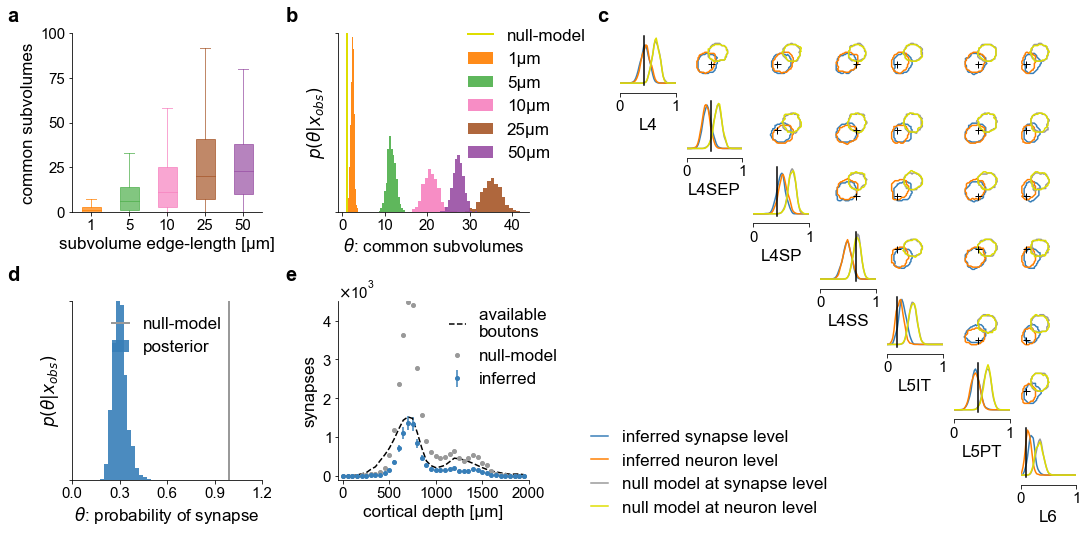

In [7]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=.2, hspace=0, width_ratios=[.5, .5])
alpha=0.9
handlelength = 1.

# First column
grid1 = outer_grid[0, 0].subgridspec(2, 2, wspace=0.4, hspace=.5)
ax1 = grid1.subplots()
# second columns
grid2 = outer_grid[0, 1].subgridspec(7, 7, wspace=0.2, hspace=.2)
ax2 = grid2.subplots()

# Common cubes features
plt.sca(ax1[0, 0])
bp1 = plt.boxplot(features[:, ::-1], notch=False, showfliers=False, 
#                   showmeans=True,
                  flierprops=dict(markeredgecolor="grey", marker="+", markersize=5),
                  labels=css[1:][::-1],
                  patch_artist=True, 
                 )
# plt.yscale("log")
plt.ylabel("common subvolumes")
plt.xlabel(r"subvolume edge-length [µm]")
color_boxplot(thos[:, 1:], bp1, colors[1:])
plt.ylim(0, 100)
plt.yticks(np.linspace(0, 100, 5))

# Common cubes posteriors
plt.sca(ax1[0, 1])
# plt
for ii in range(1, 6):
    plt.hist(thos[:, -ii], bins=15, histtype="stepfilled", 
             alpha=alpha, 
             color=colors[:7][ii],
             density=True, 
             label=f"{css[-ii]}µm"
            )
plt.xlabel(r"$\theta$: common subvolumes")
plt.ylabel(r"$p(\theta | x_{obs})$")
plt.xticks(np.linspace(0, 40, 5))
plt.ylim(0, 1)
plt.yticks([0, 1], ["", ""])
# plt.axvline(x=1, color=colors[8], label="1µm \nfixed "+r"$\theta=1$", lw=2)
plt.axvline(x=1, color=colors[8], label="null-model", lw=2)
plt.legend(bbox_to_anchor=(0.6, .2), handlelength=1.5,)

# Subcellular rule posterior
plt.sca(ax1[1, 0])
plt.hist(thos[:, 0], bins=np.arange(0, 1, 0.025), histtype="stepfilled", 
         alpha=alpha, 
         color=colors[0],
         density=True, 
         label="posterior"
        )
plt.ylabel(r"$p(\theta | x_{obs})$")
plt.xlabel(r"$\theta$: probability of synapse")
# plt.axvline(x=.99, color=colors[6], label=r"fixed $\theta$", lw=2)
plt.axvline(x=.99, color=colors[6], label="null-model", lw=2)
plt.xlim(0, 1.2)
plt.ylim(0, 9)
plt.yticks([0, 9], ["", ""])
plt.xticks(np.linspace(0, 1.2, 5))
plt.legend(loc=9, 
           handlelength=handlelength,
#            bbox_to_anchor=(5.5, -6), 
          );

fig, ax2 = pairplot([xos[0], xos[-2], xos_fixed[0], xos_fixed[1]], points=xo, 
                    points_colors=["k"], 
                    points_offdiag=dict(marker="+", markersize=7), 
                    samples_colors = [colors[0], colors[1], colors[6], colors[8]],
                    labels=xo_labels,
         limits=[[0, 1]]*7,
         diag="kde",
         hist_diag=dict(histtype="step", bins=10),
         upper="contour", 
         contour_offdiag=dict(levels=[0.95]),
         fig=fig, 
         axes=ax2,
        )
plt.sca(ax2[0, 0])
plt.legend(["inferred synapse level", 
            "inferred neuron level", 
            "null model at synapse level", 
            "null model at neuron level",
           ], 
           handlelength=handlelength,
           bbox_to_anchor=(4., -6));

ax = ax1[1, 1]
plt.sca(ax)
markersize = 4
# for better displaying we divide the total number of boutons by the number of VPM neurons.
# i.e. we plot the average number of boutons per VPM neuron.
ax.plot(depths, num_boutons_per_depth / num_vpm_neurons, linestyle='--', 
#         marker='o', 
        color='k', label='available \nboutons')
ax.errorbar(depths, 
            y=x_per_depth.mean(0) / num_vpm_neurons, 
            yerr=(x_per_depth / num_vpm_neurons).std(0), 
            linestyle='None', 
            marker='o', ms=markersize,
            color=colors[0], 
            label='inferred')
ax.plot(depths, xp1_per_depth / num_vpm_neurons, 
            linestyle='None', 
            marker='o', ms=markersize,
            color=colors[6],
            label="null-model")
ax.set_ylabel(r'synapses')
ax.set_xlabel(r'cortical depth [µm]')
plt.legend(handlelength=handlelength, 
           bbox_to_anchor=(.5, 1.05), 
#            markerfirst=False,
           frameon=False,
          )
num_ticks = 5

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)

plt.ylim(-100, 4500)
plt.yticks(np.linspace(0, 4000, num_ticks))
# plt.yscale("log")
plt.xlim(-50, 2000)
plt.xticks(np.linspace(0, 2000, num_ticks))

# Add Letters.
weight = "bold"
fontsize = 20
x = 0.075
y = 0.92
dy = .47
dx = 0.29
fig.text(x, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(dx, y, "b", fontsize=fontsize, fontweight=weight)
fig.text(dx + 0.24, y, "c", fontsize=fontsize, fontweight=weight);
fig.text(x, dy, "d", fontsize=fontsize, fontweight=weight)
fig.text(dx, dy, "e", fontsize=fontsize, fontweight=weight);

In [23]:
fig.savefig("figure4-sbi_with_rule_variants.png", dpi=300, bbox_inches='tight')

## Version October 22

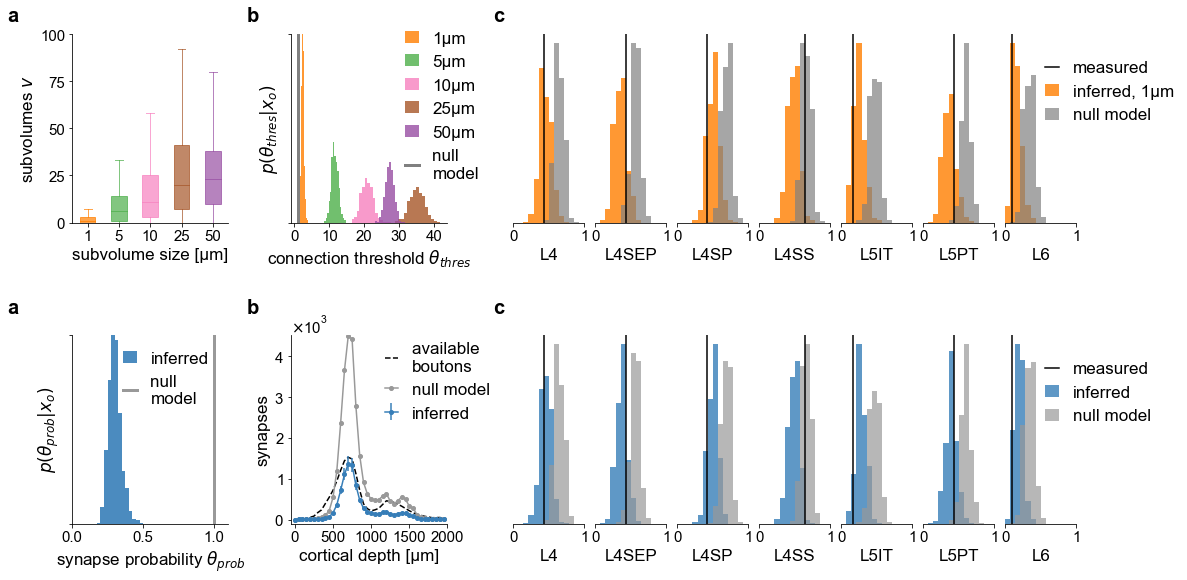

In [8]:
fig = plt.figure(figsize=(18, 9))
outer_grid = fig.add_gridspec(1, 2, wspace=.14, hspace=0, width_ratios=[.4, .6])
alpha=0.9
handlelength = 0.8
hspace_rows = 0.6

# First column
grid1 = outer_grid[0, 0].subgridspec(2, 2, wspace=0.4, hspace=hspace_rows)
ax1 = grid1.subplots()
# second columns
grid2 = outer_grid[0, 1].subgridspec(2, 1, wspace=0.0, hspace=hspace_rows)
grid21 = grid2[0, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax2 = grid21.subplots(subplot_kw=dict(sharey=True))

grid22 = grid2[1, 0].subgridspec(1, 7, wspace=0.15, hspace=0.)
ax3 = grid22.subplots(subplot_kw=dict(sharey=True))

# Common cubes features
plt.sca(ax1[0, 0])
bp1 = plt.boxplot(features[:, ::-1], notch=False, showfliers=False, 
#                   showmeans=True,
                  flierprops=dict(markeredgecolor="grey", marker="+", markersize=5),
                  labels=css[1:][::-1],
                  patch_artist=True, 
                 )
# plt.yscale("log")
plt.ylabel(fr"subvolumes $v$")
plt.xlabel(r"subvolume size [µm]")
color_boxplot(thos[:, 1:], bp1, colors[1:])
plt.ylim(0, 100)
plt.yticks(np.linspace(0, 100, 5))

# Common cubes posteriors
plt.sca(ax1[0, 1])
# plt
for ii in range(1, 6):
    plt.hist(thos[:, -ii], bins=15, histtype="stepfilled", 
             alpha=0.8, 
             color=colors[:7][ii],
             density=True, 
             label=f"{css[-ii]}µm"
            )
plt.xlabel(r"connection threshold $\theta_{thres}$")
plt.ylabel(r"$p(\theta_{thres} | x_{o})$")
plt.xticks(np.linspace(0, 40, 5))
plt.ylim(0, 1)
plt.yticks([0, 1], ["", ""])
# plt.axvline(x=1, color=colors[8], label="1µm \nfixed "+r"$\theta=1$", lw=2)
plt.axvline(x=1, 
            color="gray", #colors[8], 
            label="null \nmodel", lw=3)
plt.legend(bbox_to_anchor=(1.3, 1.1), 
           handlelength=handlelength,
           loc="upper right",
          )

# Subcellular rule posterior
plt.sca(ax1[1, 0])
plt.hist(thos[:, 0], bins=np.arange(0, 1, 0.025), histtype="stepfilled", 
         alpha=alpha, 
         color=colors[0],
         density=True, 
         label="inferred"
        )
plt.ylabel(r"$p(\theta_{prob} | x_{o})$")
plt.xlabel(r"synapse probability $\theta_{prob}$")
# plt.axvline(x=.99, color=colors[6], label=r"fixed $\theta$", lw=2)
plt.axvline(x=1.0, color=colors[6], label="null \nmodel", lw=3)
plt.xlim(0, 1.1)
plt.ylim(0, 9)
plt.yticks([0, 9], ["", ""])
plt.xticks(np.linspace(0, 1, 3))
plt.legend(loc="upper center", 
           handlelength=handlelength,
           bbox_to_anchor=(.6, 1.0), 
          );


## Posterior predictive
bins = np.linspace(0, 1, 15)
bbox_to_anchor = (.35, .45)
ii = 1  # plot only 1mu subvolume posterior.
custom_marginal_plot(ax2, xos[-ii].numpy(), xo, 
                     x_label=f"inferred, {css[-ii]}µm", 
                     points_label="measured", 
                     show_xlabels=True,
                     labels=xo_labels,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[:7][ii], 
                     plot_legend=False,
                     handlelength=handlelength,
                     histtype="stepfilled",
                     alpha=0.8,
#                      bbox_to_anchor=(0.28, .9)
                    )

custom_marginal_plot(ax2, xos_fixed[1].numpy(), 
                     points=None, 
                     x_label=f"null model",
                     points_label="measured", 
                     show_xlabels=False,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color="gray", #colors[8], 
                     alpha=0.7,
                     plot_legend=False,
                     histtype="stepfilled",)

plt.sca(ax2[-1])
plt.legend(handlelength=handlelength,
           bbox_to_anchor=bbox_to_anchor, 
           loc="lower left",
          );

# subcellular level
custom_marginal_plot(ax3, x=xos[0].numpy(), points=xo, 
                     x_label=f"inferred", 
                     points_label="measured", 
                     show_xlabels=False,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[0], 
                     plot_legend=False,
                     alpha=0.8,
#                      bbox_to_anchor=(0.28, .9)
                    )

custom_marginal_plot(ax3, xos_fixed[0].numpy(), 
                     points=None, 
                     x_label=f"null model",
                     points_label="measured", 
                     show_xlabels=True,
                     labels=xo_labels,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[6], 
                     alpha=0.7,
                     plot_legend=False,
                     bbox_to_anchor=(.7, .7))
plt.sca(ax3[-1])
plt.legend(handlelength=handlelength,
           bbox_to_anchor=bbox_to_anchor, 
           loc="lower left",
          );

ax = ax1[1, 1]
plt.sca(ax)
markersize = 4
# for better displaying we divide the total number of boutons by the number of VPM neurons.
# i.e. we plot the average number of boutons per VPM neuron.
ax.plot(depths, num_boutons_per_depth / num_vpm_neurons, linestyle='--', 
#         marker='o', 
        color='k', label='available \nboutons')
ax.errorbar(depths, 
            y=x_per_depth.mean(0) / num_vpm_neurons, 
            yerr=(x_per_depth / num_vpm_neurons).std(0), 
            linestyle='-', 
            marker='o', ms=markersize,
            color=colors[0], 
            label='inferred')
ax.plot(depths, xp1_per_depth / num_vpm_neurons, 
            linestyle='-', 
            marker='o', ms=markersize,
            color=colors[6],
            label="null model")
ax.set_ylabel(r'synapses')
ax.set_xlabel(r'cortical depth [µm]')
plt.legend(handlelength=handlelength, 
           bbox_to_anchor=(.5, 1.05), 
#            markerfirst=False,
           frameon=False,
          )
num_ticks = 5

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)

plt.ylim(-100, 4500)
plt.yticks(np.linspace(0, 4000, num_ticks))
# plt.yscale("log")
plt.xlim(-50, 2000)
plt.xticks(np.linspace(0, 2000, num_ticks))

# Add Letters.
weight = "bold"
fontsize = 20
x = 0.075
y = 0.9
dy = .45
dx = 0.26
dx2 = 0.45
fig.text(x, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(dx, y, "b", fontsize=fontsize, fontweight=weight)
fig.text(dx2, y, "c", fontsize=fontsize, fontweight=weight);
fig.text(x, dy, "a", fontsize=fontsize, fontweight=weight)
fig.text(dx, dy, "b", fontsize=fontsize, fontweight=weight);
fig.text(dx2, dy, "c", fontsize=fontsize, fontweight=weight);

In [9]:
fig.savefig("figure4-sbi_with_rule_variants_seperate.png", dpi=300, bbox_inches='tight')
fig.savefig("figure4-sbi_with_rule_variants_seperate.pdf", dpi=300, bbox_inches='tight')